In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pyloki.config import ParamLimits, PulsarSearchConfig
from pyloki.core.basic import generate_branching_pattern
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig


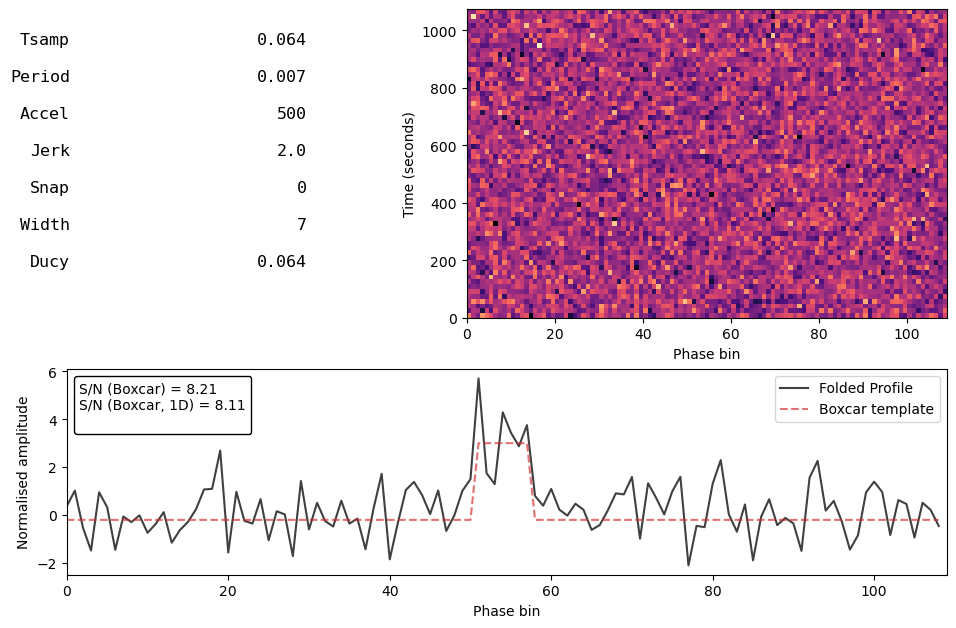

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 500
jerk = 2.0
nsamps = 2**24
mod_kwargs = {"acc": accel, "jerk": jerk}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=8, ducy=0.1,
                        mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 #cfg.tol_bins
fold_bins = 64 # cfg.fold_bins
p = ParamLimits.from_upper([jerk, accel, cfg.freq], (-jerk * 3, jerk * 3), cfg.tobs)
print(p.limits)
bseg_brute = cfg.nsamps // 2048
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=3)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

[(np.float64(-6.0), np.float64(6.0)), (np.float64(-2721.225472), np.float64(3721.225472)), (np.float64(142.31718522301608), np.float64(143.39710049126967))]


2025-03-27 18:45:46 INFO     - pyloki.ffa - FFA initialize: Grid sizes: [1.08800739e+07 9.50715361e+05             
                             5.96046448e-02]

                    INFO     - pyloki.ffa - ffa level:  0, leaves: 4.17, fold dims: (2048, 1, 1, 18, 2, 64)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 0.137 seconds

Output()

2025-03-27 18:45:50 INFO     - pyloki.ffa - ffa level:  1, leaves:  5.17, fold dims: (1024, 1, 1, 36, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  2, leaves:  6.17, fold dims: (512, 1, 1, 72, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  3, leaves:  7.17, fold dims: (256, 1, 1, 144, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  4, leaves:  8.17, fold dims: (128, 1, 1, 289, 2, 64)

                    INFO     - pyloki.ffa - FFA complete: Grid sizes: [2.65626803e+03 3.71373188e+03               
                             3.72529030e-03]

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 4.486 seconds

In [4]:
branching_pattern = generate_branching_pattern(dyp.param_arr, dyp.dparams_limited, dyp.cfg.param_limits, dyp.cfg.tseg_ffa, dyp.nsegments - 1,
                                               dyp.cfg.nbins, dyp.cfg.tol_bins, 0)
branching_pattern

array([4, 9, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
thresholds = np.array([2.1, 2.3, 2.3, 2.3, 2.2, 2.7, 2.8, 2.7, 2.6, 2.5, 2.7, 2.9, 2.8,
       3.2, 3.4, 3.6, 3.5, 3.6, 3.6, 3.7, 3.9, 4. , 3.9, 4.1, 3.8, 4.2,
       4.1, 4. , 4. , 4. , 3.9, 4.3, 4.4, 4.2, 4.1, 4.2, 4.1, 4.1, 4.1,
       4.6, 4.6, 4.7, 4.5, 4.3, 4.5, 4.3, 4.4, 4.2, 4.3, 4.2, 4.1, 4.3,
       4.8, 5.1, 5.1, 5.1, 5.1, 5. , 4.9, 5. , 4.9, 4.8, 4.7, 4.9, 4.7,
       4.9, 4.9, 4.5, 5. , 4.9, 4.8, 5. , 5. , 4.8, 5.1, 5.1, 5.2, 5.1,
       5.2, 5.2, 4.9, 5.2, 4.9, 5.2, 5.2, 5.2, 5.1, 5.1, 5.3, 5.1, 5.3,
       5.2, 5. , 5.4, 5.4, 5.3, 5.5, 5.5, 5.5, 5.4, 5.5, 5.6, 5.5, 5.5,
       5.5, 5.7, 5.3, 5.7, 5.8, 5.4, 5.8, 5.7, 5.9, 5.8, 5.6, 6. , 5.9,
       5.7, 5.9, 5.6, 6.1, 6. , 5.7, 6. , 6.1, 5.8, 6.1])
ref_segs=[0, 20, 40, 60]
# Make sure the output directory exists
result_file = prune_dyp_tree(dyp, ref_segs, thresholds, max_sugg=2**22, outdir="jerk_test/", file_prefix="test_jerk",
                             kind="taylor", n_workers=4)

2025-03-27 18:46:13 INFO     - pyloki.prune - Starting Pruning for 4 runs, with 4 workers

Output()

2025-03-27 18:46:16 INFO     - worker_000 - Initializing pruning run with ref segment: 0

                    INFO     - worker_020 - Initializing pruning run with ref segment: 20

2025-03-27 18:46:17 INFO     - worker_040 - Initializing pruning run with ref segment: 40

                    INFO     - worker_060 - Initializing pruning run with ref segment: 60

                    INFO     - worker_000 - prune_initialize finished, Elapsed time: 1.266 seconds

2025-03-27 18:46:18 INFO     - worker_060 - prune_initialize finished, Elapsed time: 0.400 seconds

                    INFO     - worker_020 - prune_initialize finished, Elapsed time: 1.224 seconds

                    INFO     - worker_040 - prune_initialize finished, Elapsed time: 1.203 seconds

2025-03-27 18:49:32 INFO     - worker_040 - Pruning run complete for ref segment: 40

                    INFO     - worker_040 - Pruning stats: Score: 7.67, Leaves: 10.10

                    INFO     - worker_040 - Pruning time: Total: 147.7s (resolve: 27% | shift_add: 26% | branch:   
                             21% | score: 13%)

2025-03-27 18:49:46 INFO     - worker_020 - Pruning run complete for ref segment: 20

                    INFO     - worker_020 - Pruning stats: Score: 7.44, Leaves: 9.53

                    INFO     - worker_020 - Pruning time: Total: 165.6s (resolve: 29% | shift_add: 25% | branch:   
                             25% | score: 11%)

2025-03-27 18:50:03 INFO     - worker_060 - Pruning run complete for ref segment: 60

                    INFO     - worker_060 - Pruning stats: Score: 7.56, Leaves: 9.77

                    INFO     - worker_060 - Pruning time: Total: 178.9s (resolve: 29% | shift_add: 26% | branch:   
                             25% | score: 10%)

2025-03-27 18:50:30 INFO     - worker_000 - Pruning run complete for ref segment: 0

                    INFO     - worker_000 - Pruning stats: Score: 7.63, Leaves: 10.33

                    INFO     - worker_000 - Pruning time: Total: 193.9s (resolve: 27% | shift_add: 26% | branch:   
                             21% | score: 13%)

2025-03-27 18:50:31 INFO     - pyloki.prune - Pruning complete. Results saved to                                   
                             jerk_test/test_jerk_pruning_nstages_128_results.h5

In [7]:
pgram = ScatteredPeriodogram.load(result_file)
jerk_true = cfg.mod_kwargs["jerk"]
acc_true = cfg.mod_kwargs["acc"]
freq_true = cfg.freq
print(f"True params, j: {jerk_true:.3f}, a: {acc_true:.3f}, f: {freq_true:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, j: 2.000, a: 500.000, f: 142.8571428571
Top candidates:
dparams: djerk: 0.001828989483, daccel: 0.4245235342, dfreq: 4.599123825e-05
Run: 040, S/N: 7.67, jerk: 5.5162, accel: 1520.99, freq: 142.918722
Run: 040, S/N: 7.64, jerk: 5.5144, accel: 1520.63, freq: 142.918751
Run: 000, S/N: 7.63, jerk: 4.5743, accel: 1196.29, freq: 143.133266
Run: 040, S/N: 7.59, jerk: 5.5181, accel: 1521.35, freq: 142.918693
Run: 060, S/N: 7.56, jerk: -2.2753, accel: -856.29, freq: 143.052539
Run: 040, S/N: 7.56, jerk: 5.5162, accel: 1520.57, freq: 142.918728
Run: 060, S/N: 7.55, jerk: 5.0425, accel: 2328.95, freq: 142.502153
Run: 060, S/N: 7.53, jerk: 4.4408, accel: 1314.08, freq: 142.833510
Run: 000, S/N: 7.51, jerk: 1.5345, accel: 2846.33, freq: 143.200931
Run: 020, S/N: 7.44, jerk: 5.0334, accel: 3520.49, freq: 143.152855


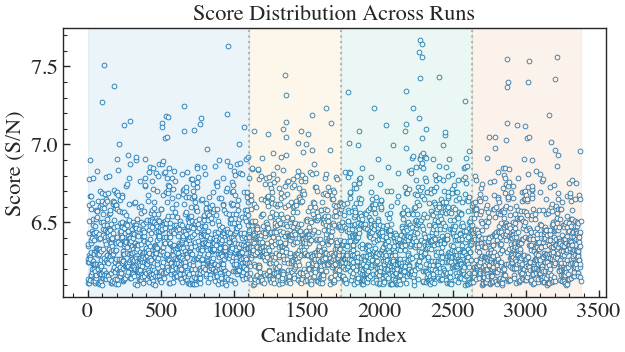

In [8]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

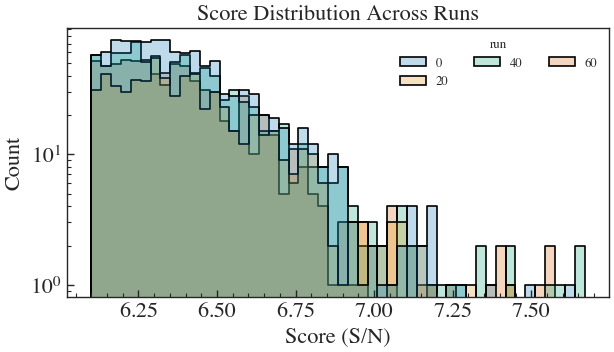

In [9]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

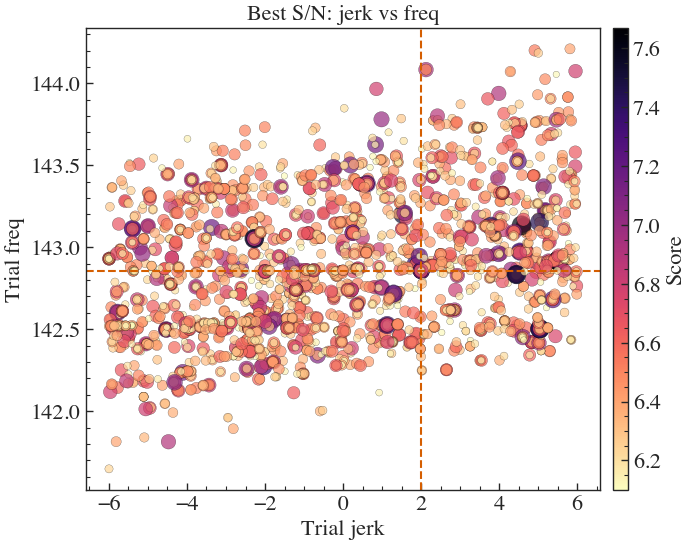

In [10]:
pgram.plot_correlation("jerk", "freq",
                       true_values={"jerk": jerk_true, "accel": acc_true, "freq": freq_true},
                       run_id=None)
plt.show()